In [83]:
import os
import glob
import sys
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import logging

import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skimage import feature, io
from scipy.stats import norm
from scipy.ndimage import label, find_objects

# Make path for scripts relative to the working directory
sys.path.insert(0, '../src')  # Adjust the path as needed

# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [32]:
# CHUNK 1 # 
# Load maximum intensity projections (MIPs) files
# and segmentation masks for images in one experiment

# Define the location of the file to read
parent_directory = "/Volumes/lionnt01lab/lionnt01labspace/Nestor_S/DIMMERs/microscope-data" # modify if needed
experiment = "08122024_pDIMMERs" # this will be changed for each experiment

# This dictionary defines the folders inside of "experiment" that contain each image type
file_folders = {
    "image": "MIPs/MIPs_multichannel/", 
    "mask_n": "segmentation-masks/nuclei_masks/", 
    "mask_b": "segmentation-masks/background_masks/"
}

# These dictionaries will store all image files and their names:
all_images = {"image": [], "mask_n": [], "mask_b": []}
file_names = {"image": [], "mask_n": [], "mask_b": []}
errors = []  # List to store error messages

# Load the function img_loadr() 
from load_files import img_loadr

# Load files with parallel processing using img_loadr() from load_files.py
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust the number of workers as needed
    for f in file_folders:
        # Build the path to the folders indicated at the top
        file_path = os.path.join(parent_directory, experiment, file_folders[f])
        files = glob.glob(os.path.join(file_path, "*.tif"))
        # Run load_image() over the list of files in the folder (files, just above)
        results = executor.map(img_loadr, files)

        for result in results:
            # Unpack the tuples in results, and save the image in all_images[] 
            # and the file names in file_names[]
            image, filename = result
            if image is not None:
                all_images[f].append(image)
                file_names[f].append(filename)

# Log the completion of image processing
if errors:
    logging.error(f"Completed with errors in {len(errors)} files.")
else:
    logging.info("All images and masks have been processed successfully without errors.")

# Optional: Summary of processed files
logging.info(f"Processed {len(file_names['image'])} images, {len(file_names['mask_n'])} nuclei masks, and {len(file_names['mask_b'])} background masks.")

# Now, all_images["image"] contains all the images (MIPs), 
# all_images["mask_n"] contains all the nuclei masks and 
# all_images["mask_b"] contains all the background masks

2024-08-19 10:54:02,102 - INFO - All images and masks have been processed successfully without errors.
2024-08-19 10:54:02,103 - INFO - Processed 113 images, 113 nuclei masks, and 0 background masks.


In [33]:
# Check dimensions of a given set of images, to verify they're correct

# Define function to check dimensions of images and masks
def img_sizr(image_types, file_indices):
    for f in file_indices:
        for image_type in image_types:
            try:
                image_shape = all_images[image_type][f].shape
                logging.info(f"File {f} ({image_type}): {image_shape}")
            except IndexError:
                logging.warning(f"File index {f} for {image_type} is out of range.")
            except KeyError:
                logging.error(f"Image type {image_type} does not exist.")

# Define the list of image types to check
image_types_to_check = ['image', 'mask_n']  # Add 'mask_b' if you want to check background masks too

# And the list of file indices to check
test_files = [10, 40]

# Run the check
img_sizr(image_types_to_check, test_files)

2024-08-19 10:54:21,578 - INFO - File 10 (image): (3, 2048, 2048)
2024-08-19 10:54:21,579 - INFO - File 10 (mask_n): (2048, 2048)
2024-08-19 10:54:21,580 - INFO - File 40 (image): (3, 2048, 2048)
2024-08-19 10:54:21,581 - INFO - File 40 (mask_n): (2048, 2048)


In [34]:
# CHUNK 2 #
# Match image indices to mask indices, to make sure they're paired correctly
# as they may not have been read in the same order

# Assuming file_names['image'] and file_names['mask_n'] contain the file names
image_file_names = file_names['image']
mask_file_names = file_names['mask_n']

# Convert list of mask filenames to a dictionary for faster lookup
mask_name_to_index = {name: idx for idx, name in enumerate(mask_file_names)}

# Match each image with its corresponding mask
matched_indices = []
missing_masks = 0
for img_index, img_name in enumerate(image_file_names):
    base_name = os.path.splitext(img_name)[0]
    mask_name = f"C1-{base_name}_cp_masks.tif"
    mask_index = mask_name_to_index.get(mask_name)

    if mask_index is not None:
        matched_indices.append((img_index, mask_index))
    else:
        missing_masks += 1
        logging.warning(f"No matching mask found for image: {img_name}")

# Log the results of the matching
logging.info(f"Matched {len(matched_indices)} images with masks. Missing masks for {missing_masks} images.")
        
# Now, matched_indices contains pairs of indices for matched image and mask

2024-08-19 10:54:24,166 - INFO - Matched 113 images with masks. Missing masks for 0 images.


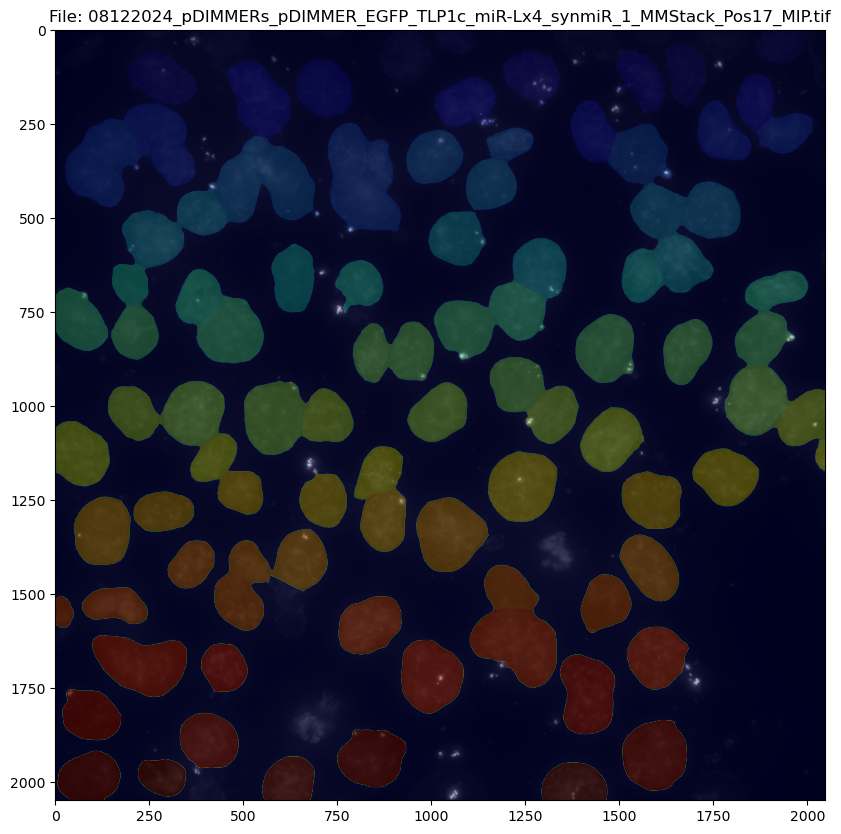

In [36]:
# Overlay the corresponding mask on a channel (given as c) of a given image
# to visually inspect

# Specify the index of the image to check
# and the channel to plot — remember CH1 for ImageJ but channel 0 for Python!
image_index = 25 # Replace with the desired index
c = 0 # remember the channel order in these images

# Find the corresponding mask index
# and define the image and mask pair
mask_index = [pair[1] for pair in matched_indices if pair[0] == image_index][0]

my_image = all_images['image'][image_index]
image_file = file_names['image'][image_index]
my_mask_n = all_images['mask_n'][mask_index]

# Select the c channel
channel_image = my_image[c, ...]

# Overlay the mask on the rest of the image if they have the same dimensions
if channel_image.shape != my_mask_n.shape:
    print("Warning: The image and mask sizes do not match. Please check your data.")
else:
    overlay = np.ma.masked_where(my_mask_n == 0, my_mask_n)
    plt.figure(figsize=(10, 10))
    plt.imshow(channel_image, cmap='gray')  # Display the selected channel in grayscale
    plt.imshow(my_mask_n, cmap='jet', alpha=0.25)  # Overlay the mask with transparency
    plt.title(f'File: {image_file}')
    #plt.axis('off')  # Turn off axis labels
    plt.show()

In [37]:
# CHUNK 3 (optional) # 
# Background analysis

# Define a function that identifies all potential background regions (ROI = 0)
def find_background_regions(nuclear_mask):
    """
    Identifies and labels distinct background regions (where ROI == 0) in a nuclear mask.

    Parameters:
    - nuclear_mask: numpy array representing the nuclear mask, where 0 denotes background.

    Returns:
    - labeled_background: numpy array with the same shape as nuclear_mask, where each
                          distinct background region is labeled with a unique integer,
                          and non-background areas are labeled as 0.
    """
    # Create a binary array where True denotes background
    background = (nuclear_mask == 0)

    # Use scipy.ndimage.label to label connected components in the background
    labeled_background, num_features = label(background)

    # The function labels all connected components. We will zero out non-background regions
    # which have been inadvertently labeled by reversing the initial condition.
    labeled_background[nuclear_mask != 0] = 0

    return labeled_background, num_features

In [38]:
# Initialize storage for the labeled backgrounds, region counts, and additional metrics
labeled_backgrounds = []
background_region_deets = []

# For each of the masks, find the background regions 
# and obtain their area and average intensity on each channel
for mask_index, nuclear_mask in enumerate(all_images['mask_n']):
    labeled_bg, num_features = find_background_regions(nuclear_mask)
    labeled_backgrounds.append(labeled_bg)
    region_details = []

    # Fetch the corresponding image for intensity calculations
    corresponding_image = all_images['image'][mask_index]

    # Process each background region
    for region_label in range(1, num_features + 1):
        region_mask = (labeled_bg == region_label)
        region_area = np.sum(region_mask)
        region_intensities = []

        # Calculate average intensity per channel within the region
        for channel_index in range(corresponding_image.shape[0]):
            channel_data = corresponding_image[channel_index]
            avg_intensity = np.mean(channel_data[region_mask])
            region_intensities.append(avg_intensity)

        # Store details for the current region
        region_details.append({
            'area': region_area,
            'avg_intensities': region_intensities
        })

    # Store details for all regions in the current mask
    background_region_deets.append(region_details)

# Now you have labeled_backgrounds storing all the labeled background masks
# and background_region_counts storing the count of regions for each mask

In [39]:
# Flatten the data structure into a list of dictionaries
data_for_df = []
for mask_index, regions in enumerate(background_region_deets):
    mask_filename = file_names['mask_n'][mask_index]  # Get the filename using the mask_index
    for region_index, details in enumerate(regions):
        # Create a dictionary for each region that includes mask index, region index, and mask filename
        region_dict = {
            'mask_index': mask_index,
            'region_index': region_index + 1,  # Add 1 to make it 1-based index
            'mask_filename': mask_filename,  # Include the filename of the mask
            'area': details['area']
        }
        
        # Add average intensities for each channel
        for channel_index, intensity in enumerate(details['avg_intensities']):
            region_dict[f'avg_intensity_channel_{channel_index}'] = intensity
        
        data_for_df.append(region_dict)

# Create a DataFrame from the list of dictionaries
bk_df = pd.DataFrame(data_for_df)
print(bk_df.head())

   mask_index  region_index  \
0           0             1   
1           0             2   
2           0             3   
3           0             4   
4           0             5   

                                       mask_filename     area  \
0  C1-08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMSt...  2015181   
1  C1-08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMSt...      150   
2  C1-08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMSt...        5   
3  C1-08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMSt...        1   
4  C1-08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMSt...        1   

   avg_intensity_channel_0  avg_intensity_channel_1  avg_intensity_channel_2  
0              3675.517848              5253.193868               179.364073  
1              1369.693333               737.013333               160.726667  
2              2459.800000              1284.200000               165.000000  
3              2833.000000              1309.000000               158.000000  
4              1120.000000 

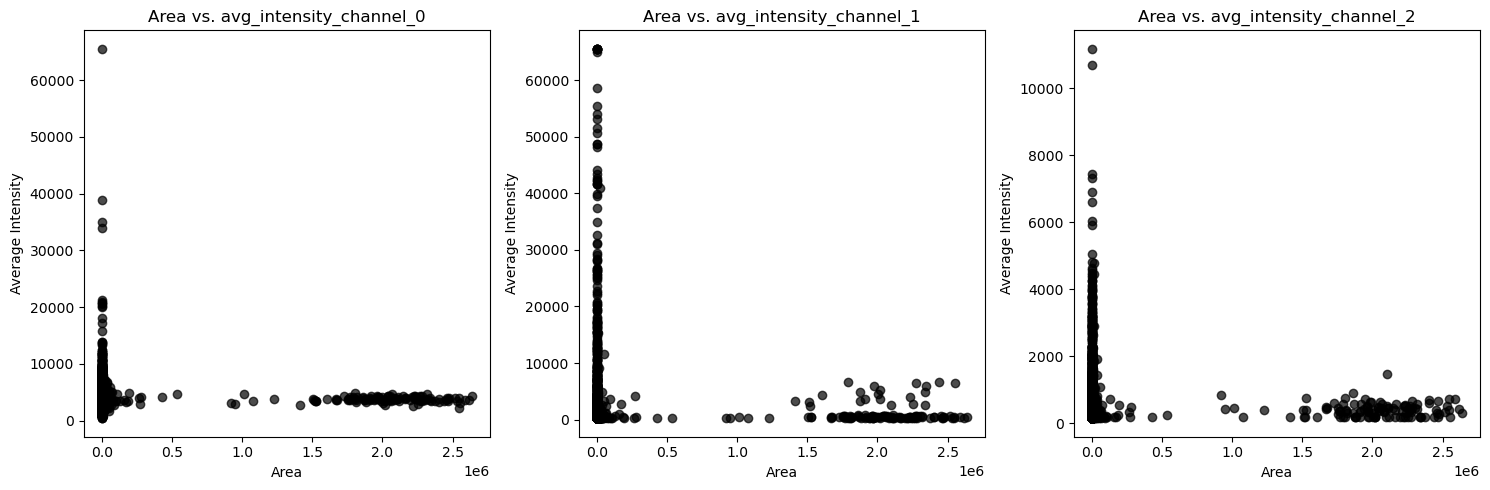

In [40]:
# Determine the number of channels from the DataFrame column names
channel_columns = [col for col in bk_df.columns if 'avg_intensity_channel_' in col]
num_channels = len(channel_columns)

# Set up the figure with subplots arranged side by side
fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))  # Adjust total width and height as needed

if num_channels == 1:  # If there's only one channel, make sure 'axes' is iterable
    axes = [axes]

# Plot each channel's intensity against the area
for idx, channel in enumerate(channel_columns):
    ax = axes[idx]
    ax.scatter(bk_df['area'], bk_df[channel], color='black', alpha=0.7)
    ax.set_title(f'Area vs. {channel}')
    ax.set_xlabel('Area')
    ax.set_ylabel('Average Intensity')

# Ensure the layout is organized to prevent overlap of plot elements
plt.tight_layout()
plt.show()

The background objects fall clearly into two categories, one with large objects that have low intensity values (the true background) and one with small objects of varying intensity levels (some as high as the nuclei, the true signal). If we do background subtraction, we should only use the large objects, with low intensity values

In [41]:
# CHUNK 3 (cont) #
# Incorporate the same operations ran above into a single step that extracts the largest background ROI
# and calculates the corresponding intensities

from background_subtraction import get_largest_background

# Initialize a list to store background values
bk_values = []
# Run through the list of images and masks and extract the metrics for the largest background
for mask_index, (mask, image) in enumerate(zip(all_images['mask_n'], all_images['image'])):
    result = get_largest_background(mask, image)  # Assuming this returns {'area': value, 'average_intensities': [list_of_values]}
    area = result['area']
    # Generate a separate entry for each channel's average intensity
    for channel, intensity in enumerate(result['average_intensities']):
        bk_values.append({
            'mask_index': mask_index,  # Keep track of which mask this data belongs to
            'channel': channel,       # Channel number
            'avg_intensity': intensity,  # Average intensity for this channel
            'area': area  # Include area if you want to keep track of it for each channel
        })


# Convert the list of formatted dictionaries to a DataFrame
import pandas as pd
bk_df = pd.DataFrame(bk_values)

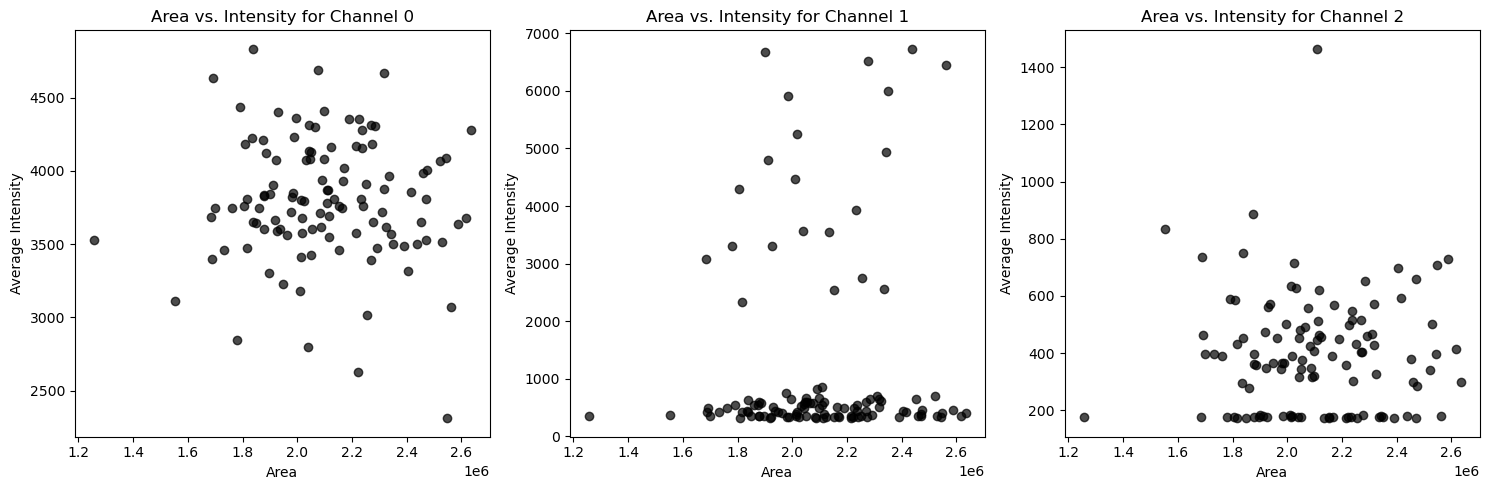

In [42]:
# Plot area vs  intensity for each channel for the true background only

# Determine the number of channels from the DataFrame column names
# Determine the number of channels from the DataFrame by examining the unique values in the 'channel' column
num_channels = bk_df['channel'].max() + 1  # Assuming channel numbers start from 0

# Set up the figure with subplots arranged side by side
fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))  # Adjust total width and height as needed

if num_channels == 1:  # If there's only one channel, make sure 'axes' is iterable
    axes = [axes]

# Plot each channel's intensity against the area
for idx in range(num_channels):
    current_df = bk_df[bk_df['channel'] == idx]
    ax = axes[idx]
    ax.scatter(current_df['area'], current_df['avg_intensity'], color='black', alpha=0.7)
    ax.set_title(f'Area vs. Intensity for Channel {idx}')
    ax.set_xlabel('Area')
    ax.set_ylabel('Average Intensity')

# Ensure the layout is organized to prevent overlap of plot elements
plt.tight_layout()
plt.show()

In [43]:
# CHUNK 4 #

# Extract a set of metrics for each ROI defined by the mask from the corresponding image
# using the measureROIs() function

from get_roi_metrics import measureROIs

# Use concurrent processing to handle images
if __name__ == '__main__':
    with ThreadPoolExecutor(max_workers=4) as executor:
        # Prepare data for processing
        tasks = [(img_index, all_images['image'][img_index], all_images['mask_n'][mask_index]) 
                 for img_index, mask_index in matched_indices]
        # Process data in parallel
        results = list(executor.map(measureROIs, tasks))

        all_roi_metrics = {f'Image {img_index}': roi_metrics for img_index, roi_metrics in results}

    logging.info("Metrics extraction complete for all ROIs across all matched images.")

# Now, all_roi_metrics contains the metrics for each ROI in each channel for each matched image

2024-08-19 10:57:56,185 - INFO - Metrics extraction complete for all ROIs across all matched images.


In [44]:
# CHUNK 4.2 #

# Do the same as above, but doing background subtraction

from get_roi_metrics import measureROIs

# Wrap get_roi_metrics into another function to pass the background subtraction argument
def measureROIs_wrapper(task):
    return measureROIs(task, subtract_background = True)

# Use concurrent processing to handle images
if __name__ == '__main__':
    with ThreadPoolExecutor(max_workers=4) as executor:
        # Prepare data for processing
        tasks = [(img_index, all_images['image'][img_index], all_images['mask_n'][mask_index]) 
                 for img_index, mask_index in matched_indices]
        # Process data in parallel
        results = list(executor.map(measureROIs_wrapper, tasks))

        bs_roi_metrics = {f'Image {img_index}': roi_metrics for img_index, roi_metrics in results}

    logging.info("Metrics extraction complete for all ROIs across all matched images.")

# Now, bs_roi_metrics contains the metrics for each ROI in each channel for each matched image with background subtracted

2024-08-19 11:01:17,676 - INFO - Metrics extraction complete for all ROIs across all matched images.


In [45]:
# CHUNK 5 #

# Turn the all_roi_metrics and the bs_roi_metrics dictionaries into Pandas data frames for easier manipulation

# List to hold each row's data
data_rows = []

# Iterate through each level of the nested dictionary to extract data
# for each channel of each ROI in each image
for image_key, rois in all_roi_metrics.items():
    image_index = int(image_key.split()[1])  # Extract image index
    file_name = image_file_names[image_index]  # Get the file name from image_file_names list
    
    for roi_key, channels in rois.items():
        for channel_key, metrics in channels.items():
            # Create a dictionary for each row of data 
            # including image, roi, channel, and metrics
            row_data = {
                "image_index": image_index,
                "filename": file_name,
                "experiment": experiment,
                "ROI_index": roi_key,
                "channel": int(channel_key.split()[1])  # Convert 'Channel X' to integer X
            }
            row_data.update(metrics)  # Add the metrics to the row

            # Append each row_data dictionary to the data_rows list
            data_rows.append(row_data)

# Convert the list of dictionaries to a DataFrame
metrics_df = pd.DataFrame(data_rows)

data_rows = []

# Iterate through each level of the nested dictionary to extract data
# for each channel of each ROI in each image
for image_key, rois in bs_roi_metrics.items():
    image_index = int(image_key.split()[1])  # Extract image index
    file_name = image_file_names[image_index]  # Get the file name from image_file_names list
    
    for roi_key, channels in rois.items():
        for channel_key, metrics in channels.items():
            # Create a dictionary for each row of data 
            # including image, roi, channel, and metrics
            row_data = {
                "image_index": image_index,
                "filename": file_name,
                "experiment": experiment,
                "ROI_index": roi_key,
                "channel": int(channel_key.split()[1])  # Convert 'Channel X' to integer X
            }
            row_data.update(metrics)  # Add the metrics to the row

            # Append each row_data dictionary to the data_rows list
            data_rows.append(row_data)

# Convert the list of dictionaries to a DataFrame
metricsBS_df = pd.DataFrame(data_rows)

In [46]:
# Display the first few rows of the DataFrame to verify it's correct
print(metricsBS_df.head())

   image_index                                           filename  \
0            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
1            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
2            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
3            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
4            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   

          experiment  ROI_index  channel   area          avg       median  \
0  08122024_pDIMMERs          1        0  14756  1081.020663  1099.801295   
1  08122024_pDIMMERs          1        1  14756 -2115.132514 -2320.448385   
2  08122024_pDIMMERs          1        2  14756    -3.634246    -8.604427   
3  08122024_pDIMMERs          2        0  13800   797.020715   797.801295   
4  08122024_pDIMMERs          2        1  13800 -2113.615849 -2318.448385   

          std        maxima       minima  
0  657.134095  10426.801295  -608.198705  
1  622.740469    955.551615 -2841.44

In [47]:
print(bk_df.head())

   mask_index  channel  avg_intensity     area
0           0        0    3675.517848  2017955
1           0        1    5253.193868  2017955
2           0        2     179.364073  2017955
3           1        0    3794.081636  2022974
4           1        1     346.157585  2022974


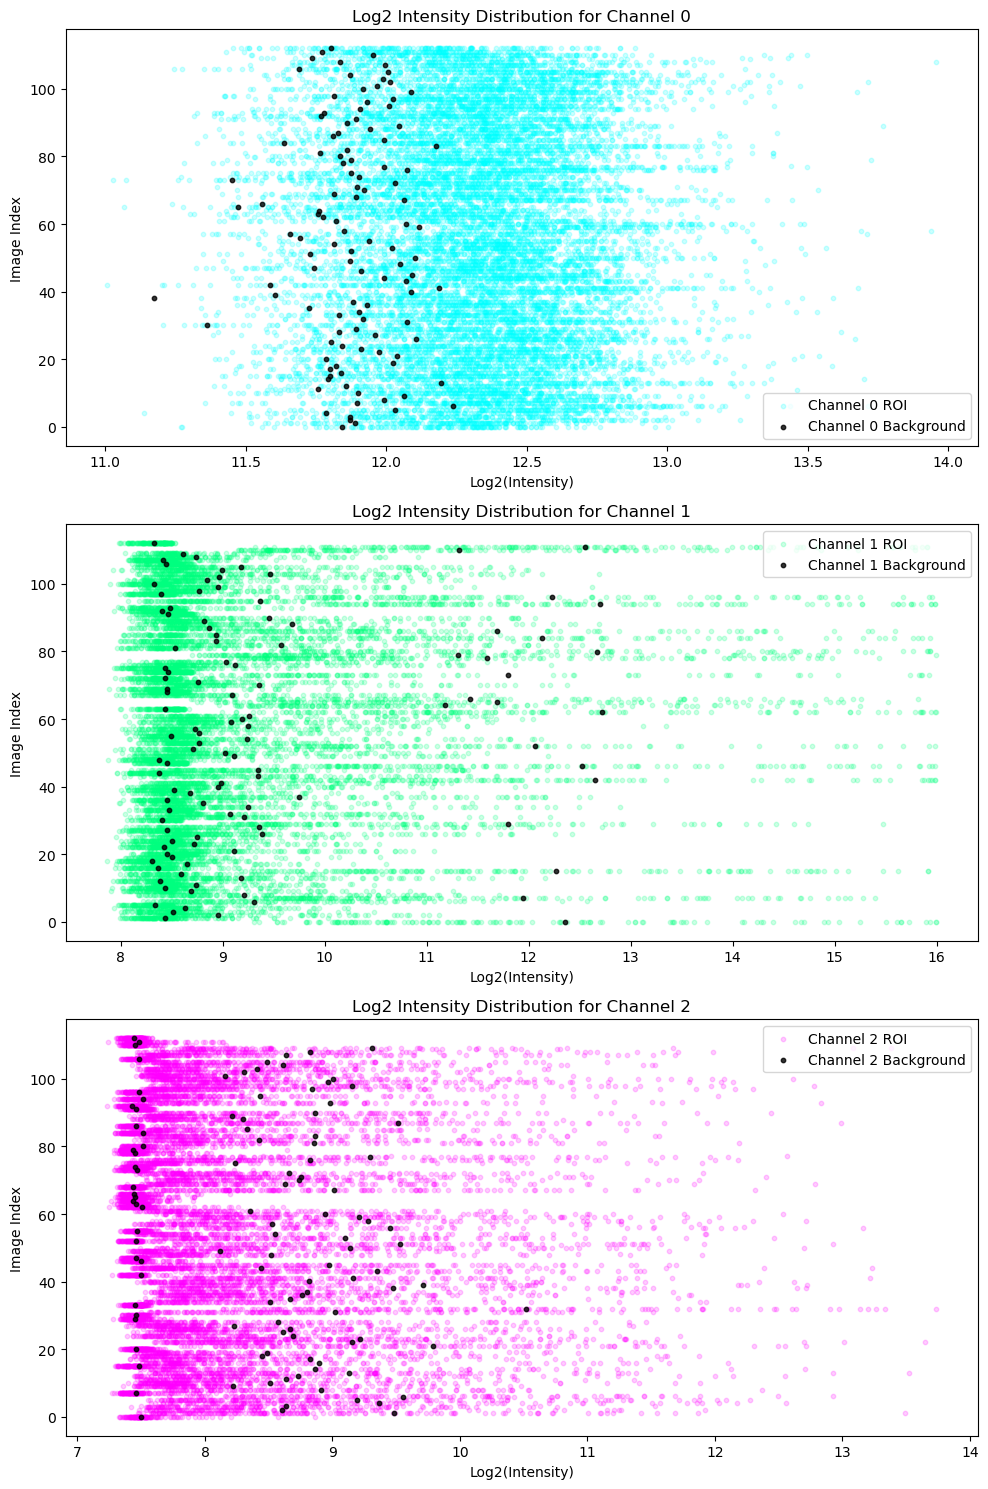

In [48]:
# Plot the background values over the nuclear values to assess if they are in the expected range:

# Define the colors for each channel
channel_colors = {0: 'cyan', 1: 'springgreen', 2: 'magenta'}

# Setup the figure
fig, ax = plt.subplots(3, 1, figsize=(10, 15))  # Wide plot

def add_jitter(values, jitter_strength=0.03):
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(values))
    return values + jitter

# Plot data for each channel
for channel, ax in enumerate(ax):
    # Get data for the current channel
    # ROI data
    roi_data = metrics_df[metrics_df['channel'] == channel]
    roi_log2_data = np.log2(roi_data['avg'] + 1)  # Log2 transform
    roi_image_indices = add_jitter(roi_data['image_index'])  # Add jitter to image index

    # Background data
    bk_data = bk_df[bk_df['channel'] == channel]
    bk_log2_data = np.log2(bk_data['avg_intensity'] + 1)  # Log2 transform
    bk_image_indices = add_jitter(bk_data['mask_index'])  # Add jitter to image index


    # Scatter plots
    # Plot ROI data
    ax.scatter(roi_log2_data, roi_image_indices, 
               color=channel_colors[channel], 
               s=10,
               alpha=0.2, 
               label=f'Channel {channel} ROI')
    # Plot Background data
    ax.scatter(bk_log2_data, bk_image_indices, 
               color='black', 
               s=10,
               alpha=0.8, 
               label=f'Channel {channel} Background')

    # Set titles and labels
    ax.set_title(f'Log2 Intensity Distribution for Channel {channel}')
    ax.set_xlabel('Log2(Intensity)')
    ax.set_ylabel('Image Index')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

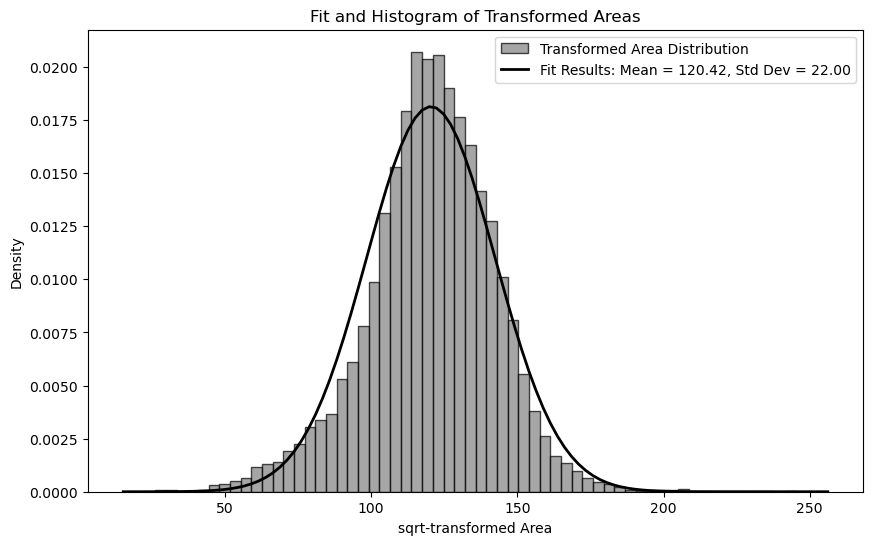

In [49]:
# Plot the distribution of ROI areas in the raw data

# Set the transformation (log or sqrt) of the data you want to visualize
tx = 'sqrt'

# Define the directory to save the plot
plot_dir = os.path.join(parent_directory, experiment, "py-plots/outlier_removal")
os.makedirs(plot_dir, exist_ok = True)

# Collect all ROI areas directly from the DataFrame
all_areas = metrics_df['area'].values

# Apply the transformation (log or sqrt)
if tx == 'log':
    tx_areas = np.log(all_areas + 1)  # Added 1 to avoid log(0)
elif tx == 'sqrt':
    tx_areas = np.sqrt(all_areas)
else:
    raise ValueError("Transformation should be either 'log' or 'sqrt'.")

# Fit a normal distribution to the transformed areas
mean, std_dev = norm.fit(tx_areas)

# Generate histogram of the transformed areas
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(tx_areas, 
                            bins=60, 
                            color='gray', 
                            edgecolor='black', 
                            linewidth=1, 
                            alpha=0.7, 
                            label='Transformed Area Distribution', 
                            density=True)
plt.xlabel(f'{tx}-transformed Area')
plt.ylabel('Density')

# Generate the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit Results: Mean = {mean:.2f}, Std Dev = {std_dev:.2f}')
plt.title('Fit and Histogram of Transformed Areas')
plt.legend()

# Save the plot to disk as a .png file
plot_filename = 'area_distr_original.png'  # Replace with your desired file name
plt.savefig(f"{plot_dir}/{plot_filename}", format='png')  # Change format to 'tif' if needed

# Show the plot on the console
plt.show()

plt.close()  # Close the plot to free memory

In [50]:
# CHUNK 6 # 

# Remove values outside the number of SD that the user defines 
# for the log or sqrt-transformed data, as above
# (2*SD seems generally reasonable for this data)
# using the outliersOut function found in outliers_removal.py

from outliers_removal import outliersOut

sd_cutoff = 2
tx = "sqrt"

filtr_metrics_df, thresholds = outliersOut(metrics_df, sd_filter = sd_cutoff, transformation = tx)

# Print the thresholds to verify them
print("Calculated thresholds:")
print(f"Mean: {thresholds[0]}, Std Dev: {thresholds[1]}")
print(f"Lower Threshold: {thresholds[2]}, Upper Threshold: {thresholds[3]}")

# Optionally, display some of the filtered data to inspect the results
# print(filtr_metrics_df.head())

Calculated thresholds:
Mean: 120.41641004534195, Std Dev: 22.003122445103337
Lower Threshold: 76.41016515513527, Upper Threshold: 164.42265493554862


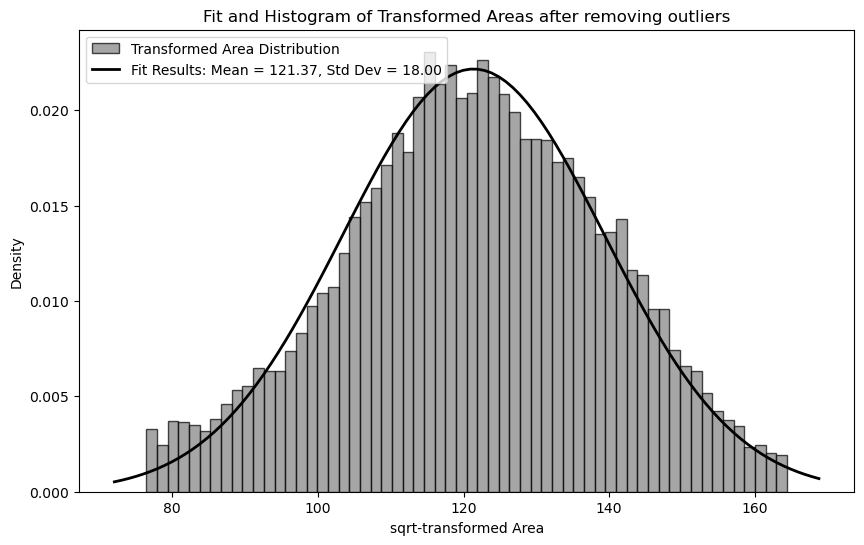

In [51]:
# Plot the distribution of ROI areas in the filtered data

# Set the transformation (log or sqrt) of the data you want to visualize
tx = 'sqrt'

# Define the directory to save the plot
plot_dir = os.path.join(parent_directory, experiment, "py-plots/outlier_removal")
os.makedirs(plot_dir, exist_ok = True)

# Collect all ROI areas directly from the DataFrame
all_areas = filtr_metrics_df['area'].values

# Apply the transformation (log or sqrt)
if tx == 'log':
    tx_areas = np.log(all_areas + 1)  # Added 1 to avoid log(0)
elif tx == 'sqrt':
    tx_areas = np.sqrt(all_areas)
else:
    raise ValueError("Transformation should be either 'log' or 'sqrt'.")

# Fit a normal distribution to the transformed areas
mean, std_dev = norm.fit(tx_areas)

# Generate histogram of the transformed areas
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(tx_areas, 
                            bins=60, 
                            color='gray', 
                            edgecolor='black', 
                            linewidth=1, 
                            alpha=0.7, 
                            label='Transformed Area Distribution', 
                            density=True)
plt.xlabel(f'{tx}-transformed Area')
plt.ylabel('Density')

# Generate the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit Results: Mean = {mean:.2f}, Std Dev = {std_dev:.2f}')
plt.title('Fit and Histogram of Transformed Areas after removing outliers')
plt.legend()

# Save the plot to disk as a .png file
plot_filename = 'area_distr_no-outliers.png'  # Replace with your desired file name
plt.savefig(f"{plot_dir}/{plot_filename}", format='png')  # Change format to 'tif' if needed

# Show the plot on the console
plt.show()

plt.close()  # Close the plot to free memory

In [52]:
# Replace these with the indices of the image, ROI, and channel you want to inspect
image_index = 7  # First image
roi_index = 9   # ROI with ID 9
channel_index = 0  # First channel

image_file = image_file_names[image_index]
image_key = f"Image {image_index}"
roi_metrics = all_roi_metrics.get(image_key, {})
roi_channel_metrics = roi_metrics.get(roi_index, {}).get(f'Channel {channel_index}', {})

print(f"Metrics for Image {image_index}, ({image_file}), ROI {roi_index}, Channel {channel_index}:")
for metric, value in roi_channel_metrics.items():
    print(f"  {metric}: {value:.2f}")

Metrics for Image 7, (08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack_Pos9_MIP.tif), ROI 9, Channel 0:
  area: 9291.00
  avg: 4452.98
  median: 4025.00
  std: 2312.89
  maxima: 30474.00
  minima: 2728.00


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


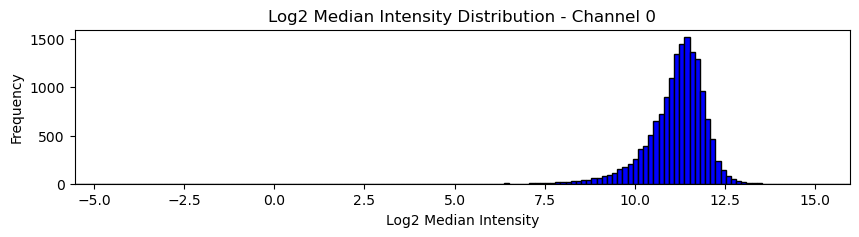

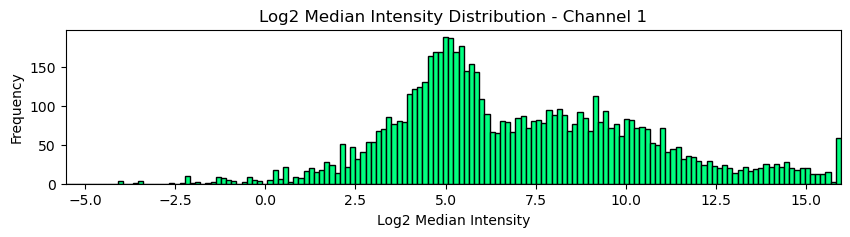

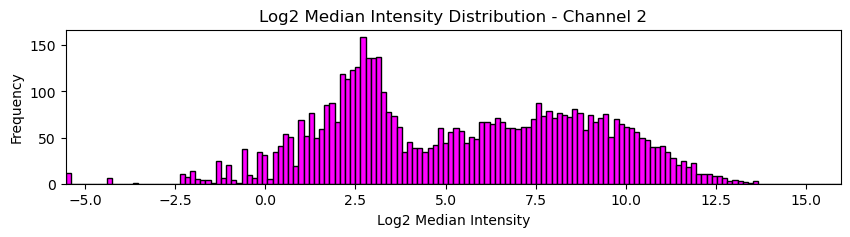

In [53]:
# Plot the data obtained above for average intensity

# Choose the metric to plot:
my_metric = 'median'
x_label = "Median Intensity"

# Transform the metric values to log2
metricsBS_df['log2_median'] = np.log2(metricsBS_df[my_metric])

# Determine global min and max for Average Intensity and max for frequency
global_min_intensity = metricsBS_df['log2_median'].min()
global_max_intensity = metricsBS_df['log2_median'].max()
max_frequency = metricsBS_df.groupby('channel')[my_metric].count().max()

# Define channel colors
# channel_colors = {0: 'blue', 1: 'springgreen', 2: 'magenta'}
channel_colors = {0: 'blue', 1: 'springgreen', 2: 'magenta'}

# Group the data by 'Channel' and then plot histograms for 'Average Intensity'
for channel, data in metricsBS_df.groupby('channel'):
    # Plot histogram for each channel
    plt.figure(figsize = (10, 2))  # Fix a 5:1 size ratio
    data['log2_median'].hist(bins = 150, 
                               color = channel_colors.get(channel, 'gray'), 
                               edgecolor = 'black', 
                               linewidth = 1, 
                               #density = True, 
                               range = (global_min_intensity, global_max_intensity))
    plt.title(f'Log2 {x_label} Distribution - Channel {channel}')
    plt.xlabel(f'Log2 {x_label}')
    plt.ylabel('Frequency')
    plt.xlim(global_min_intensity, global_max_intensity)
    #plt.ylim(0, max_frequency)
    plt.grid(False)  # Optionally turn off the grid
    plt.show()

In [57]:
# Changing the filenames in CSV so I can later add a joined data frame to filter by plasmid type 
# Load the CSV file into a DataFrame
experimental_groups = '/Volumes/lionnt01lab/lionnt01labspace/Nestor_S/DIMMERs/microscope-data/08122024_pDIMMERs/experimental-groups.csv'
df = pd.read_csv(experimental_groups)

# Replace '.ome.' with '_MIP' in the filenames
df['filename'] = df['filename'].str.replace('.ome', '_MIP')

metrics_joined_df = pd.merge(metrics_df, df, left_on='filename', right_on='filename', how='left')
print(metrics_joined_df.head())

   image_index                                           filename  \
0            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
1            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
2            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
3            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
4            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   

          experiment  ROI_index  channel   area          avg  median  \
0  08122024_pDIMMERs          1        0  14756  3757.219368  3776.0   
1  08122024_pDIMMERs          1        1  14756  1854.315872  1649.0   
2  08122024_pDIMMERs          1        2  14756   171.970182   167.0   
3  08122024_pDIMMERs          2        0  13800  3473.219420  3474.0   
4  08122024_pDIMMERs          2        1  13800  1855.832536  1651.0   

          std  maxima  minima     tx_area  experiment_folder  \
0  657.134095   13103    2068  121.474277  08122024_pDIMMERs   
1  622.740469    4925   

In [58]:
metricsBS_joined_df = pd.merge(metricsBS_df, df, left_on='filename', right_on='filename', how='left')
print(metricsBS_joined_df.head())

   image_index                                           filename  \
0            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
1            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
2            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
3            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
4            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   

          experiment  ROI_index  channel   area          avg       median  \
0  08122024_pDIMMERs          1        0  14756  1081.020663  1099.801295   
1  08122024_pDIMMERs          1        1  14756 -2115.132514 -2320.448385   
2  08122024_pDIMMERs          1        2  14756    -3.634246    -8.604427   
3  08122024_pDIMMERs          2        0  13800   797.020715   797.801295   
4  08122024_pDIMMERs          2        1  13800 -2113.615849 -2318.448385   

          std        maxima       minima  log2_median  experiment_folder  \
0  657.134095  10426.801295  -608.198705    10

metricsBS_joined_df = exptBS_1_df and metrics_joined_df = expt_1_df --> both are data frames for expt 1 

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


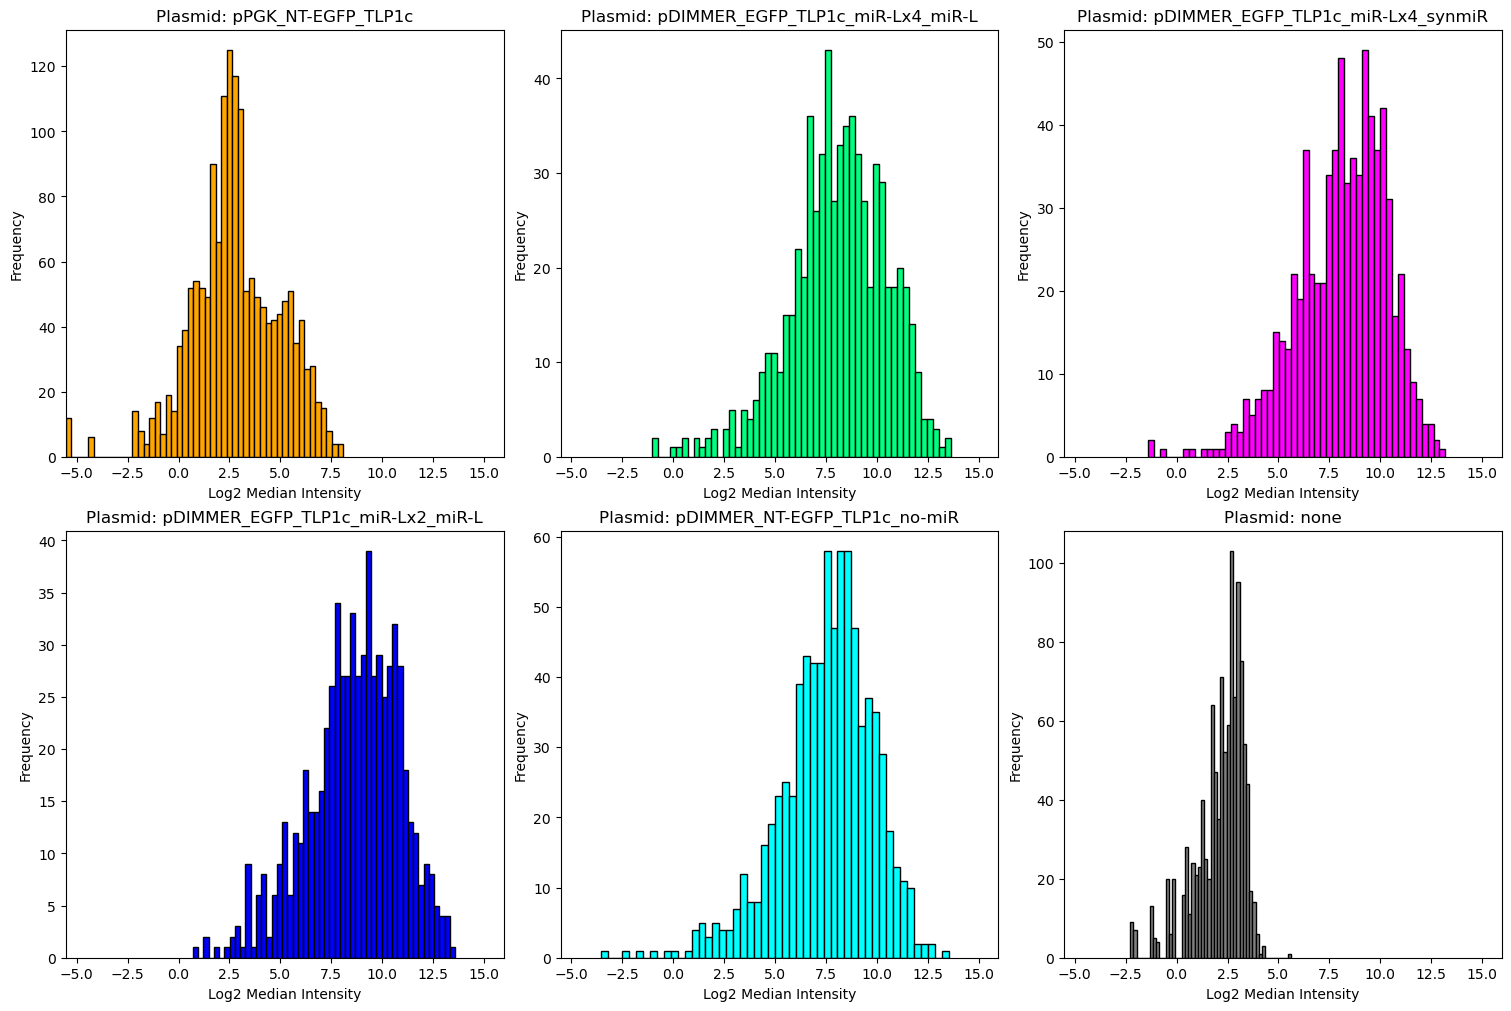

In [59]:
# Choose the channel and metric to plot
channel_to_plot = 2
my_metric = 'median'
x_label = "Median Intensity"

# Apply log2 transformation
metricsBS_joined_df['log2_median'] = np.log2(metricsBS_joined_df[my_metric])

# Define colors for each plasmid type
plasmid_colors = {
    'pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L': 'blue',
    'pDIMMER_EGFP_TLP1c_miR-Lx4_miR-L': 'springgreen',
    'pDIMMER_EGFP_TLP1c_miR-Lx4_synmiR': 'magenta',
    'pDIMMER_NT-EGFP_TLP1c_no-miR': 'cyan',
    'pPGK_NT-EGFP_TLP1c': 'orange',
    'none': 'gray'
}

# Extract unique plasmid types from the DataFrame
plasmids = metricsBS_joined_df['plasmid'].unique() 

# Determine global min and max for Average Intensity and max for frequency
global_min_intensity = metricsBS_joined_df['log2_median'].min()
global_max_intensity = metricsBS_joined_df['log2_median'].max()
max_frequency = metricsBS_joined_df[metricsBS_joined_df['channel'] == channel_to_plot].groupby('plasmid')['log2_median'].count().max()

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

# Plot histograms for each plasmid type
for i, plasmid in enumerate(plasmids):
    # Filter data for the specific plasmid and channel
    filtered_data = metricsBS_joined_df[(metricsBS_joined_df['plasmid'] == plasmid) & (metricsBS_joined_df['channel'] == channel_to_plot)]

    # Plot histogram
    ax = axes[i]
    ax.hist(filtered_data['log2_median'], bins=50, 
            color=plasmid_colors.get(plasmid, 'gray'), 
            edgecolor='black', 
            linewidth=1)
    ax.set_title(f'Plasmid: {plasmid}')
    ax.set_xlabel(f'Log2 {x_label}')
    ax.set_ylabel('Frequency')
    ax.set_xlim(global_min_intensity, global_max_intensity)
   # ax.set_ylim(0, max_frequency)
    ax.grid(False)  # Optionally turn off the grid

# Hide any unused subplots (if any)
for j in range(len(plasmids), len(axes)):
    axes[j].axis('off')

plt.show()

In [72]:
# Concatenate the DataFrames row-wise --> to use for graphing scatter plots 
combined_df = pd.concat([metrics_joined_df, expt_1_df], axis=0)
print(combined_df.head())

   image_index                                           filename  \
0            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
1            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
2            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
3            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
4            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   

          experiment  ROI_index  channel   area          avg  median  \
0  08122024_pDIMMERs          1        0  14756  3757.219368  3776.0   
1  08122024_pDIMMERs          1        1  14756  1854.315872  1649.0   
2  08122024_pDIMMERs          1        2  14756   171.970182   167.0   
3  08122024_pDIMMERs          2        0  13800  3473.219420  3474.0   
4  08122024_pDIMMERs          2        1  13800  1855.832536  1651.0   

          std  maxima  minima     tx_area  experiment_folder  \
0  657.134095   13103    2068  121.474277  08122024_pDIMMERs   
1  622.740469    4925   

Number of points within threshold for pDIMMER_NT-EGFP_TLP1c_no-miR: 1032
Number of points within threshold for pPGK_NT-EGFP_TLP1c: 117
Number of points within threshold for pDIMMER_EGFP_TLP1c_miR-Lx4_miR-L: 1103
Number of points within threshold for none: 2686
Number of points within threshold for pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L: 815
Number of points within threshold for pDIMMER_EGFP_TLP1c_miR-Lx4_synmiR: 792


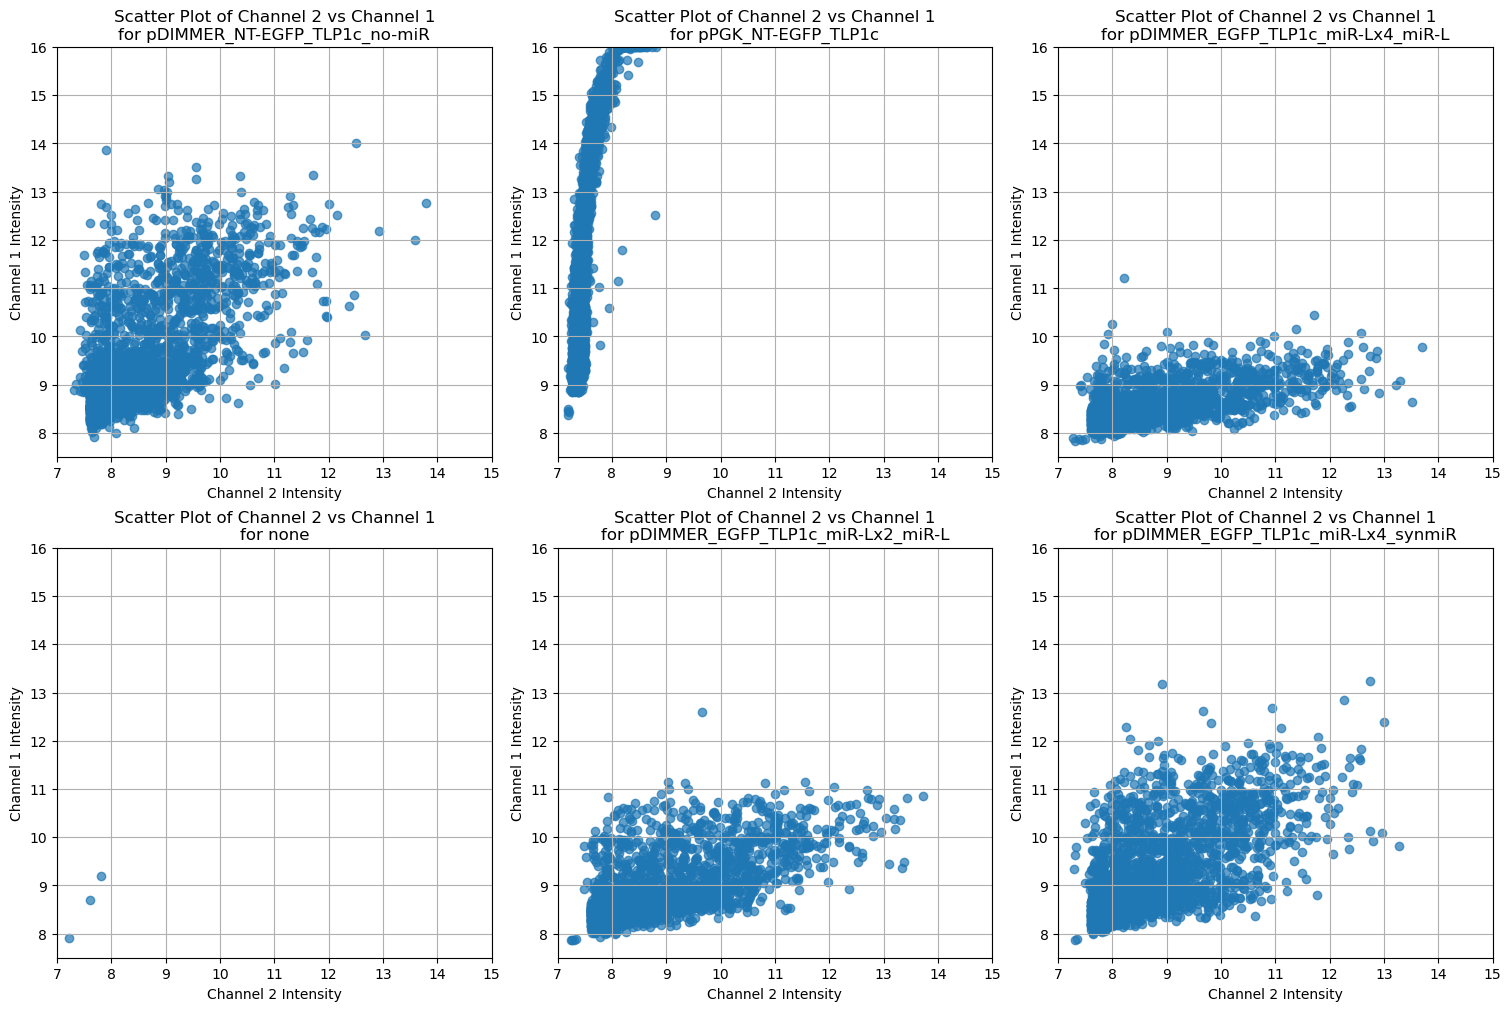

In [66]:
# Toggle channels for Scatter Plot
channel_x = 2
channel_y = 1

# Calculate the statistics for the "none" group for each channel
none_group = combined_df[combined_df['plasmid'] == 'none']

none_mean_x = none_group[none_group['channel'] == channel_x]['median'].mean()
none_std_x = none_group[none_group['channel'] == channel_x]['median'].std()
none_mean_y = none_group[none_group['channel'] == channel_y]['median'].mean()
none_std_y = none_group[none_group['channel'] == channel_y]['median'].std()

# Define the range as mean ± 3 * standard deviation
threshold_low_x = none_mean_x - 3 * none_std_x
threshold_high_x = none_mean_x + 3 * none_std_x
threshold_low_y = none_mean_y - 3 * none_std_y
threshold_high_y = none_mean_y + 3 * none_std_y

# Extract unique plasmid types from the DataFrame
plasmids = combined_df['plasmid'].unique()

# Create a grid layout for subplots
num_plasmids = len(plasmids)
cols = 3  # Number of columns
rows = (num_plasmids + cols - 1) // cols  # Number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)

# Flatten axes array to easily iterate when plotting
axes = axes.flatten()

for i, plasmid in enumerate(plasmids):
    # Apply the filter based on plasmid
    filtered_df = combined_df[combined_df['plasmid'] == plasmid]

    # Filter data for the chosen channels within the already filtered DataFrame
    data_x = filtered_df[filtered_df['channel'] == channel_x]
    data_y = filtered_df[filtered_df['channel'] == channel_y]

    # Ensure both dataframes have the same index for merging
    data_x = data_x.reset_index(drop=True)
    data_y = data_y.reset_index(drop=True)

    # Apply log2 transformation to the median values
    data_x['log2_median'] = np.log2(data_x['median'])
    data_y['log2_median'] = np.log2(data_y['median'])

    # Combine the data for scatter plot
    scatter_df = pd.concat([data_x[['log2_median']].rename(columns={'log2_median': 'x_intensity'}), 
                             data_y[['log2_median']].rename(columns={'log2_median': 'y_intensity'})], axis=1)

    # Check if the points fall within the threshold before filtering
    within_threshold = (scatter_df['x_intensity'] >= np.log2(threshold_low_x)) & \
                       (scatter_df['x_intensity'] <= np.log2(threshold_high_x)) & \
                       (scatter_df['y_intensity'] >= np.log2(threshold_low_y)) & \
                       (scatter_df['y_intensity'] <= np.log2(threshold_high_y))
                       
    print(f"Number of points within threshold for {plasmid}: {within_threshold.sum()}")

    # Filter out points that fall within the defined range of the "none" group
    scatter_combined_df = scatter_df[~within_threshold]

    # Plot scatter plot on the appropriate axis
    ax = axes[i]
    ax.scatter(scatter_combined_df['x_intensity'], scatter_combined_df['y_intensity'], alpha=0.7)

    # Set titles for scatter plots 
    ax.set_title(f'Scatter Plot of Channel {channel_x} vs Channel {channel_y}\nfor {plasmid}')
    ax.set_xlabel(f'Channel {channel_x} Intensity')
    ax.set_ylabel(f'Channel {channel_y} Intensity')
    ax.grid(True)

    # Define fixed axis limits and intervals
    x_max = 15 
    x_interval = 1
    y_max = 16
    y_interval = 1

    # Set x-axis limits and y-axis limits with intervals
    ax.set_xlim([7, x_max])
    ax.set_ylim([7.5, y_max])
    ax.yaxis.set_major_locator(plt.MultipleLocator(y_interval)) 
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_interval)) 

# Hide unused subplots if plasmids < rows * cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

Number of points within threshold for pPGK_NT-EGFP_TLP1c: 117
Number of points within threshold for pDIMMER_EGFP_TLP1c_miR-Lx4_miR-L: 1103
Number of points within threshold for pDIMMER_EGFP_TLP1c_miR-Lx4_synmiR: 792
Number of points within threshold for pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L: 815
Number of points within threshold for pDIMMER_NT-EGFP_TLP1c_no-miR: 1032
Number of points within threshold for none: 2686


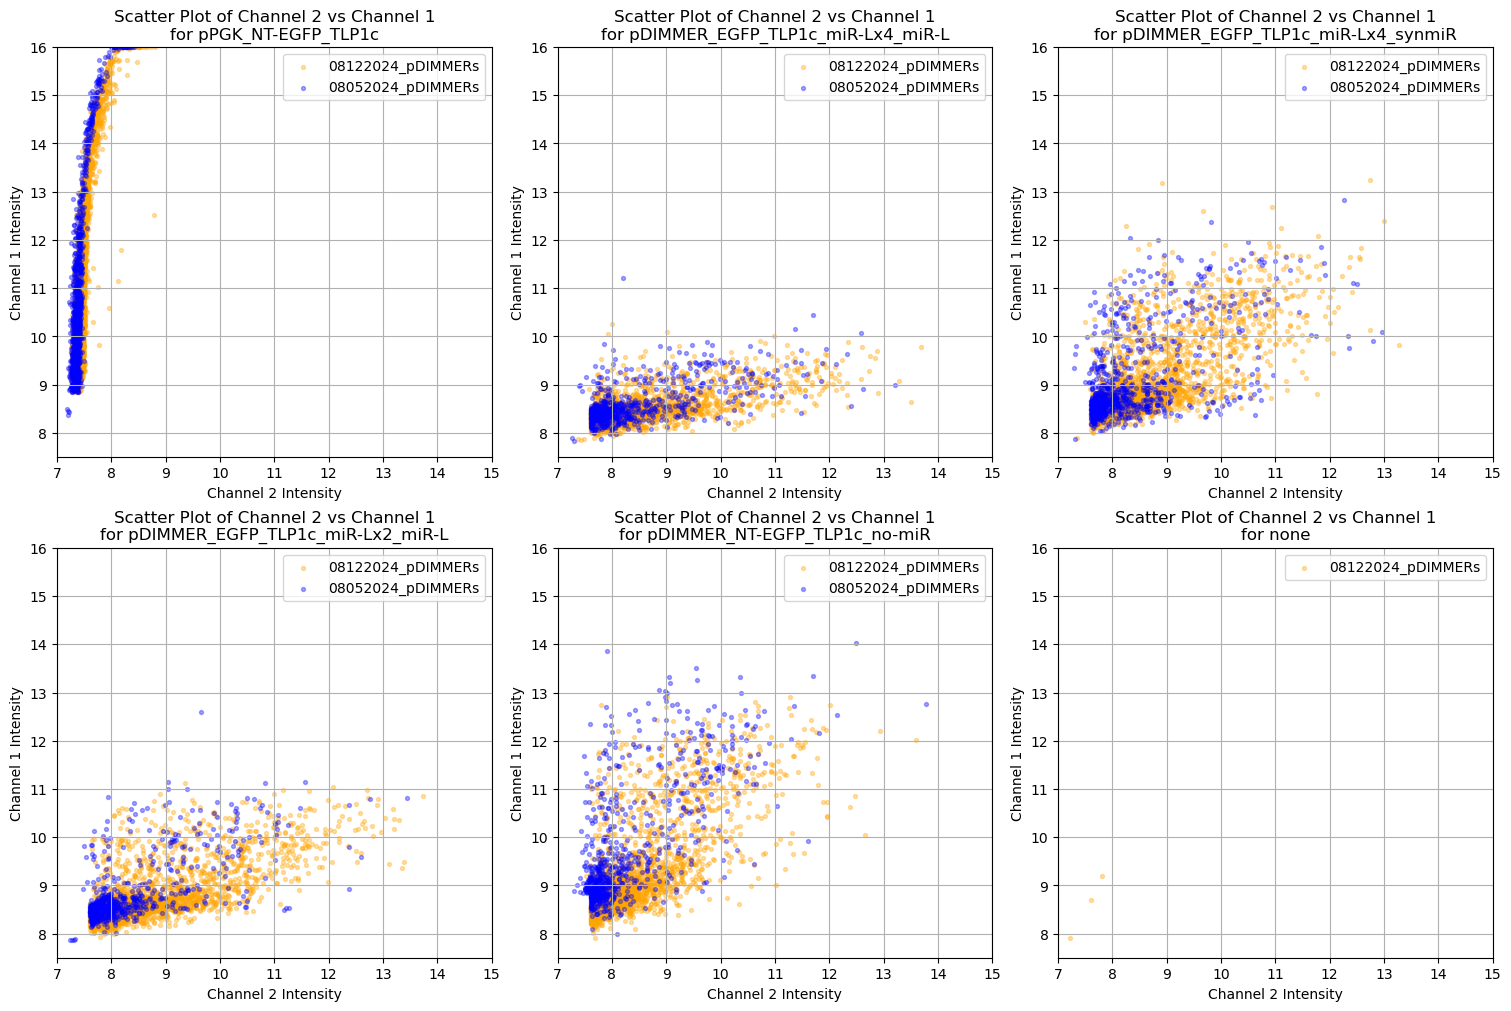

In [78]:
# Toggle channels for Scatter Plot
channel_x = 2
channel_y = 1

# Calculate the statistics for the "none" group for each channel
none_group = combined_df[combined_df['plasmid'] == 'none']

none_mean_x = none_group[none_group['channel'] == channel_x]['median'].mean()
none_std_x = none_group[none_group['channel'] == channel_x]['median'].std()
none_mean_y = none_group[none_group['channel'] == channel_y]['median'].mean()
none_std_y = none_group[none_group['channel'] == channel_y]['median'].std()

# Define the range as mean ± 3 * standard deviation
threshold_low_x = none_mean_x - 3 * none_std_x
threshold_high_x = none_mean_x + 3 * none_std_x
threshold_low_y = none_mean_y - 3 * none_std_y
threshold_high_y = none_mean_y + 3 * none_std_y

# Extract unique plasmid types from the DataFrame
plasmids = combined_df['plasmid'].unique()

# Define a color map for the experiment folders
color_map = {
    '08122024_pDIMMERs': 'orange',
    '08052024_pDIMMERs': 'blue'
    
}

# Create a grid layout for subplots
num_plasmids = len(plasmids)
cols = 3  # Number of columns
rows = (num_plasmids + cols - 1) // cols  # Number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)

# Flatten axes array to easily iterate when plotting
axes = axes.flatten()

for i, plasmid in enumerate(plasmids):
    # Apply the filter based on plasmid
    filtered_df = combined_df[combined_df['plasmid'] == plasmid]

    # Filter data for the chosen channels within the already filtered DataFrame
    data_x = filtered_df[filtered_df['channel'] == channel_x]
    data_y = filtered_df[filtered_df['channel'] == channel_y]

    # Ensure both dataframes have the same index for merging
    data_x = data_x.reset_index(drop=True)
    data_y = data_y.reset_index(drop=True)

    # Apply log2 transformation to the median values
    data_x['log2_median'] = np.log2(data_x['median'])
    data_y['log2_median'] = np.log2(data_y['median'])

    # Combine the data for scatter plot
    scatter_df = pd.concat([data_x[['log2_median', 'experiment_folder']].rename(columns={'log2_median': 'x_intensity'}), 
                             data_y[['log2_median']].rename(columns={'log2_median': 'y_intensity'})], axis=1)

    # Check if the points fall within the threshold before filtering
    within_threshold = (scatter_df['x_intensity'] >= np.log2(threshold_low_x)) & \
                       (scatter_df['x_intensity'] <= np.log2(threshold_high_x)) & \
                       (scatter_df['y_intensity'] >= np.log2(threshold_low_y)) & \
                       (scatter_df['y_intensity'] <= np.log2(threshold_high_y))
                       
    print(f"Number of points within threshold for {plasmid}: {within_threshold.sum()}")

    # Filter out points that fall within the defined range of the "none" group
    scatter_combined_df = scatter_df[~within_threshold]

    # Plot scatter plot on the appropriate axis
    ax = axes[i]
    for experiment_folder in scatter_combined_df['experiment_folder'].unique():
        sub_df = scatter_combined_df[scatter_combined_df['experiment_folder'] == experiment_folder]
        ax.scatter(sub_df['x_intensity'], sub_df['y_intensity'], color=color_map[experiment_folder], alpha=0.35, s=8, label=experiment_folder)

    # Set titles for scatter plots 
    ax.set_title(f'Scatter Plot of Channel {channel_x} vs Channel {channel_y}\nfor {plasmid}')
    ax.set_xlabel(f'Channel {channel_x} Intensity')
    ax.set_ylabel(f'Channel {channel_y} Intensity')
    ax.grid(True)

    # Define fixed axis limits and intervals
    x_max = 15 
    x_interval = 1
    y_max = 16
    y_interval = 1

    # Set x-axis limits and y-axis limits with intervals
    ax.set_xlim([7, x_max])
    ax.set_ylim([7.5, y_max])
    ax.yaxis.set_major_locator(plt.MultipleLocator(y_interval)) 
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_interval)) 

    # Add legend to indicate experiment folders
    ax.legend()

# Hide unused subplots if plasmids < rows * cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [102]:
# Initialize an empty DataFrame to store the processed data
# For future use in graphs/charts/etc. 
processed_df = pd.DataFrame()

for plasmid in plasmids:
    # Apply the filter based on plasmid
    filtered_df = combined_df[combined_df['plasmid'] == plasmid]

    # Filter data for the chosen channels within the already filtered DataFrame
    data_x = filtered_df[filtered_df['channel'] == channel_x]
    data_y = filtered_df[filtered_df['channel'] == channel_y]

    # Ensure both dataframes have the same index for merging
    data_x = data_x.reset_index(drop=True)
    data_y = data_y.reset_index(drop=True)

    # Apply log2 transformation to the median values
    data_x['log2_median_x'] = np.log2(data_x['median'])
    data_y['log2_median_y'] = np.log2(data_y['median'])

    # Merge data_x and data_y to keep all original columns
    merged_df = data_x.copy()
    merged_df['log2_median_y'] = data_y['log2_median_y']

    # Check if the points fall within the threshold before filtering
    within_threshold = (merged_df['log2_median_x'] >= np.log2(threshold_low_x)) & \
                       (merged_df['log2_median_x'] <= np.log2(threshold_high_x)) & \
                       (merged_df['log2_median_y'] >= np.log2(threshold_low_y)) & \
                       (merged_df['log2_median_y'] <= np.log2(threshold_high_y))
                       
    # Filter out points that fall within the defined range of the "none" group
    filtered_merged_df = merged_df[~within_threshold]

    # Append the processed data for this plasmid to the main DataFrame
    processed_df = pd.concat([processed_df, filtered_merged_df], ignore_index=True)

# Now `processed_df` contains all the processed data with original columns, which you can use later
print(processed_df.head())

   image_index                                           filename  \
0            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
1            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
2            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
3            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   
4            0  08122024_pDIMMERs_pPGK_NT-EGFP_TLP1c_2_MMStack...   

          experiment  ROI_index  channel   area         avg  median  \
0  08122024_pDIMMERs          1        2  14756  171.970182   167.0   
1  08122024_pDIMMERs          2        2  13800  168.586522   168.0   
2  08122024_pDIMMERs          3        2  12088  184.558984   176.0   
3  08122024_pDIMMERs          4        2  12912  187.964761   181.0   
4  08122024_pDIMMERs          5        2  14458  172.979043   172.0   

         std  maxima  minima     tx_area  experiment_folder  \
0  25.199697     432     139  121.474277  08122024_pDIMMERs   
1   7.962251     240     134  11

/var/folders/tf/f1_wyw0x3pb52tmwg0143_gx9sr5bl/T/ipykernel_57278/697632049.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='plasmid', y='median', data=filtered_df, palette='Set2', order=plasmid_order)


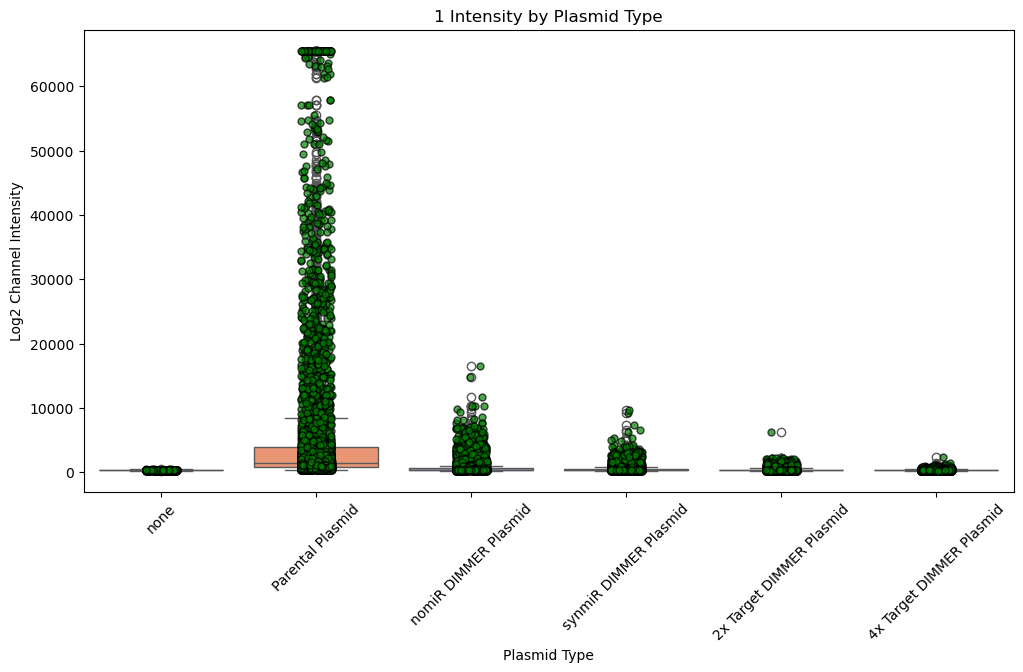

In [101]:
# Define the channel you want to plot on the y-axis for the box plot
channel_to_plot = 1  # Change this to the desired channel

# Filter the DataFrame for the selected channel
filtered_df = combined_df[combined_df['channel'] == channel_to_plot].copy()

# Create the box plot with jittered points
plt.figure(figsize=(12, 6))

# Define the order of plasmid types
plasmid_order = ['none', 'pPGK_NT-EGFP_TLP1c', 'pDIMMER_NT-EGFP_TLP1c_no-miR', 'pDIMMER_EGFP_TLP1c_miR-Lx4_synmiR', 'pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L', 'pDIMMER_EGFP_TLP1c_miR-Lx4_miR-L']  # Replace with actual plasmid types in desired order

# Create the box plot
sns.boxplot(x='plasmid', y='median', data=filtered_df, palette='Set2', order=plasmid_order)

# Add jittered points with custom color and outline
sns.stripplot(x='plasmid', y='median', data=filtered_df, 
              color='green',  # Color of the jitter points
              edgecolor='black',  # Outline color
              linewidth=1,  # Outline width
              alpha=0.7,  # Transparency of the points
              jitter=True, 
              dodge=True,
              order=plasmid_order)

# Add titles andlabels
plt.title(f'{channel_to_plot} Intensity by Plasmid Type')
plt.xlabel('Plasmid Type')
plt.ylabel('Log2 Channel Intensity')

# Define custom labels for the x-axis
custom_labels = {
    'none': 'none',
    'pPGK_NT-EGFP_TLP1c': 'Parental Plasmid',
    'pDIMMER_NT-EGFP_TLP1c_no-miR': 'nomiR DIMMER Plasmid',
    'pDIMMER_EGFP_TLP1c_miR-Lx4_synmiR': 'synmiR DIMMER Plasmid',
    'pDIMMER_EGFP_TLP1c_miR-Lx2_miR-L': '2x Target DIMMER Plasmid',
    'pDIMMER_EGFP_TLP1c_miR-Lx4_miR-L': '4x Target DIMMER Plasmid',
    # Add more mappings as needed
}

# Update x-axis labels with custom labels
plt.xticks(ticks=range(len(plasmid_order)), labels=[custom_labels.get(label, label) for label in plasmid_order], rotation=45)

# Show plot
plt.show()

/var/folders/tf/f1_wyw0x3pb52tmwg0143_gx9sr5bl/T/ipykernel_57278/1418807507.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='plasmid', y='log2_median_y', data=processed_df, palette='Set2', order=plasmid_order)


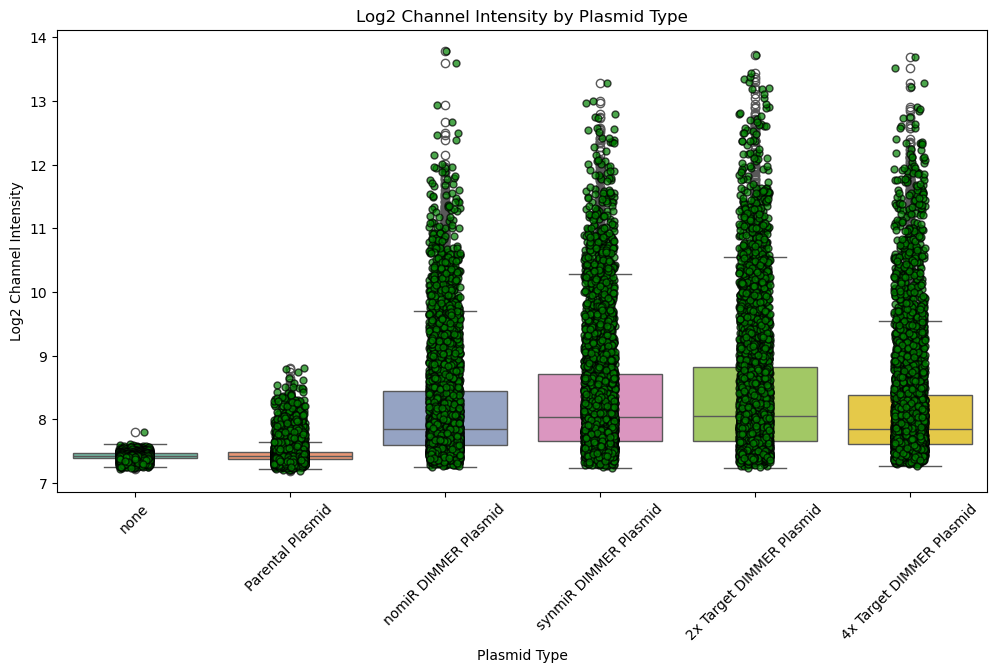

In [103]:
# Directly plot using log2_median_y without filtering by channel
plt.figure(figsize=(12, 6))

sns.boxplot(x='plasmid', y='log2_median_y', data=processed_df, palette='Set2', order=plasmid_order)
sns.stripplot(
    x='plasmid', 
    y='log2_median_y', 
    data=processed_df, 
    color='green',
    edgecolor='black',
    linewidth=1,
    alpha=0.7,
    jitter=True,
    dodge=True,
    order=plasmid_order
)

plt.title('Log2 Channel Intensity by Plasmid Type')
plt.xlabel('Plasmid Type')
plt.ylabel('Log2 Channel Intensity')
plt.xticks(ticks=range(len(plasmid_order)), labels=[custom_labels.get(label, label) for label in plasmid_order], rotation=45)

plt.show()

In [ ]:
# Test different parameter values

# Parameters to test
my_values = [0.001, 0.005, 0.01, 0.05, 0.1]  # Adjust with your values

# Select channel 2 for testing
channel = 1
image = my_image[channel]

# Number of subplots needed (one for each value in min_sigma_values)
num_subplots = len(my_values)

# Set up a large enough figure to hold all subplots
plt.figure(figsize=(15, 3 * num_subplots))

# Loop over each min_sigma value and perform blob detection
for idx, threshold_rep in enumerate(my_values):
    # Detect blobs
    blobs_log = feature.blob_log(image.astype(float), min_sigma=0.05, max_sigma=5, num_sigma=10, threshold_rel=threshold_rel)

    # Create a subplot for each min_sigma value
    plt.subplot(1, num_subplots, idx + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'threshold_rel = {threshold_rel}')

    # Plot the blobs
    for blob in blobs_log:
        y, x, r = blob
        c = plt.Circle((x, y), r*500, color='red', linewidth=2, fill=False)
        plt.gca().add_patch(c)

    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Find spots in FISH channel

# Make a dictionary to store blob information per ROI
blobs_per_roi = {}

# fish_params: min_sigma = 0.05, max_sigma = 5, num_sigma = 10, threshold_rel = 0.3

# Iterate over each channel in 'my_image'
# looking for blobs
for channel_index in range(my_image.shape[0]):
    image = my_image[channel_index]

    # Detect blobs using Laplacian of Gaussian
    # Adjust these parameters as necessary for your data
    blobs_log = feature.blob_log(image.astype(float), 
                                 min_sigma = 0.05, 
                                 max_sigma = 5, 
                                 num_sigma = 10, 
                                 threshold_rel = 0.3)

    # Filter detected blobs to be within ROIs defined in my_nucmask
    for blob in blobs_log:
        y, x, r = blob  # Blob position and estimated radius
        roi_id = my_nucmask[int(y), int(x)]
        if roi_id != 0:  # Check if inside an ROI
            if roi_id not in blobs_per_roi:
                blobs_per_roi[roi_id] = []
            blobs_per_roi[roi_id].append((channel_index, x, y, r))



In [ ]:
# Visualize the result of FISH spot detection

# Select a channel to visualize, e.g., the first channel
selected_channel = 2
plt.figure(figsize=(10, 10))
plt.imshow(my_image[selected_channel], cmap='gray')

# Plot the blobs
for blob_info in blobs_per_roi.values():
    for blob in blob_info:
        channel, x, y, r = blob
        if channel == selected_channel:  # Only plot blobs for the selected channel
            c = plt.Circle((x, y), r*250, color='red', linewidth = 1, fill = False)
            plt.gca().add_patch(c)
            
plt.title(f'Blobs in Channel {selected_channel}')
plt.axis('off')
plt.show()

In [ ]:
# Try to find spots in IF channel using same parameters as for FISH channel (chunk above)

# Specified ROIs to focus on
selected_rois = [9, 10, 11, 14, 16, 17, 20, 26, 29]

# Parameters for blob detection (these work well for FISH, channel 2)
# min_sigma = 0.05
# max_sigma = 5
# num_sigma = 10
# threshold_rel = 0.3

# Parameters for blob detection (adjust these for channel 1)
min_sigma = 0.05
max_sigma = 5
num_sigma = 10

# Parameters to test
threshold_values = [0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32] # adjust as needed

# Set up a figure for subplots
n_cols = 3
n_rows = -(-len(threshold_values) // n_cols)  # Ceiling division to get number of rows
plt.figure(figsize=(15, 5 * n_rows))  # Adjust the size as needed

# Select channel 1 for blob detection
channel_index = 1
image = my_image[channel_index]

# Dictionary to store blob information for each ROI
blobs_per_roi = {}

# Iterate over each threshold_rel value
for i, threshold_rel in enumerate(threshold_values):
    # Detect blobs using Laplacian of Gaussian for the entire image
    blobs_log = feature.blob_log(image.astype(float), 
                                 min_sigma=min_sigma, 
                                 max_sigma=max_sigma, 
                                 num_sigma=num_sigma, 
                                 threshold_rel=threshold_rel)

    # Create a subplot for each threshold_rel value
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(image, cmap='gray')

    # Filter and plot blobs for selected ROIs
    for blob in blobs_log:
        y, x, r = blob
        roi_id = my_nucmask[int(y), int(x)]
        if roi_id in selected_rois:
            c = plt.Circle((x, y), r*250, color='red', linewidth=1, fill=False)
            plt.gca().add_patch(c)

    plt.title(f'threshold_rel = {threshold_rel}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Assuming 'my_image' and 'my_nucmask' are defined
channel = 1
image = my_image[channel]

# Specified ROIs to focus on
selected_rois = [9, 10, 11, 14, 16, 17, 20, 26, 29]

# Parameters for blob detection (adjust these for channel 1)
min_sigma = 0.05
max_sigma = 5
num_sigma = 10

# After testing with the script in the previous chunk, 
# I find that the following threshold_rel values are best for the given mean intensities
known_intensities = [900, 1200, 1500, 2200, 2800]
known_thresholds = [0.096, 0.125, 0.19, 0.24, 0.285]

# Fit a quadratic polynomial (degree 2) to known data
coefficients = np.polyfit(known_intensities, known_thresholds, 2)
polynomial = np.poly1d(coefficients)

# Make a dictionary to store blob information per ROI
blobs_per_roi = {}

# Detect blobs using Laplacian of Gaussian for the entire image
threshold_rel_avg = np.mean([polynomial(np.mean(image[my_nucmask == roi_id])) for roi_id in selected_rois])
blobs_log = feature.blob_log(image.astype(float), 
                             min_sigma = min_sigma, 
                             max_sigma = max_sigma, 
                             num_sigma = num_sigma, 
                             threshold_rel=threshold_rel_avg)

# Filter detected blobs to be within the selected ROIs
for blob in blobs_log:
    y, x, r = blob
    roi_id = my_nucmask[int(y), int(x)]
    if roi_id in selected_rois:
        if roi_id not in blobs_per_roi:
            blobs_per_roi[roi_id] = []
        blobs_per_roi[roi_id].append((x, y, r))

# Visualization
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
for roi_id, blobs in blobs_per_roi.items():
    for x, y, r in blobs:
        c = plt.Circle((x, y), r * 250, color='red', linewidth=1, fill=False)
        plt.gca().add_patch(c)
plt.axis('off')
plt.title('Detected Blobs in Channel 1')
plt.show()